<a href="https://colab.research.google.com/github/Suliman8/FYP-1/blob/main/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading dataset from: /content/UNSW_NB15_feature_engineered.csv
Dataset loaded successfully!

Excluded columns (to prevent data leakage):
  - attack_cat_encoded
  - id
  - label
  - attack_freq

Feature matrix shape: (175341, 72)
Target vector shape: (175341,)

Training set shape: (140272, 72)
Testing set shape: (35069, 72)

Class distribution in training set:
label
1    0.680621
0    0.319379
Name: proportion, dtype: float64

1. Training XGBoost with default parameters...
Base model CV F1 scores: [0.96885723 0.96874756 0.96838222 0.96814293 0.97002753]
Mean F1 Score (CV): 0.969 (+/- 0.001)

2. Performing hyperparameter tuning...
Fitting 3 folds for each of 486 candidates, totalling 1458 fits

Best parameters found:
{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 200, 'subsample': 1.0}
Best cross-validation F1 score: 0.970

3. Classification Report (Tuned Parameters):
              precision    recall  f1-score   support

           0       

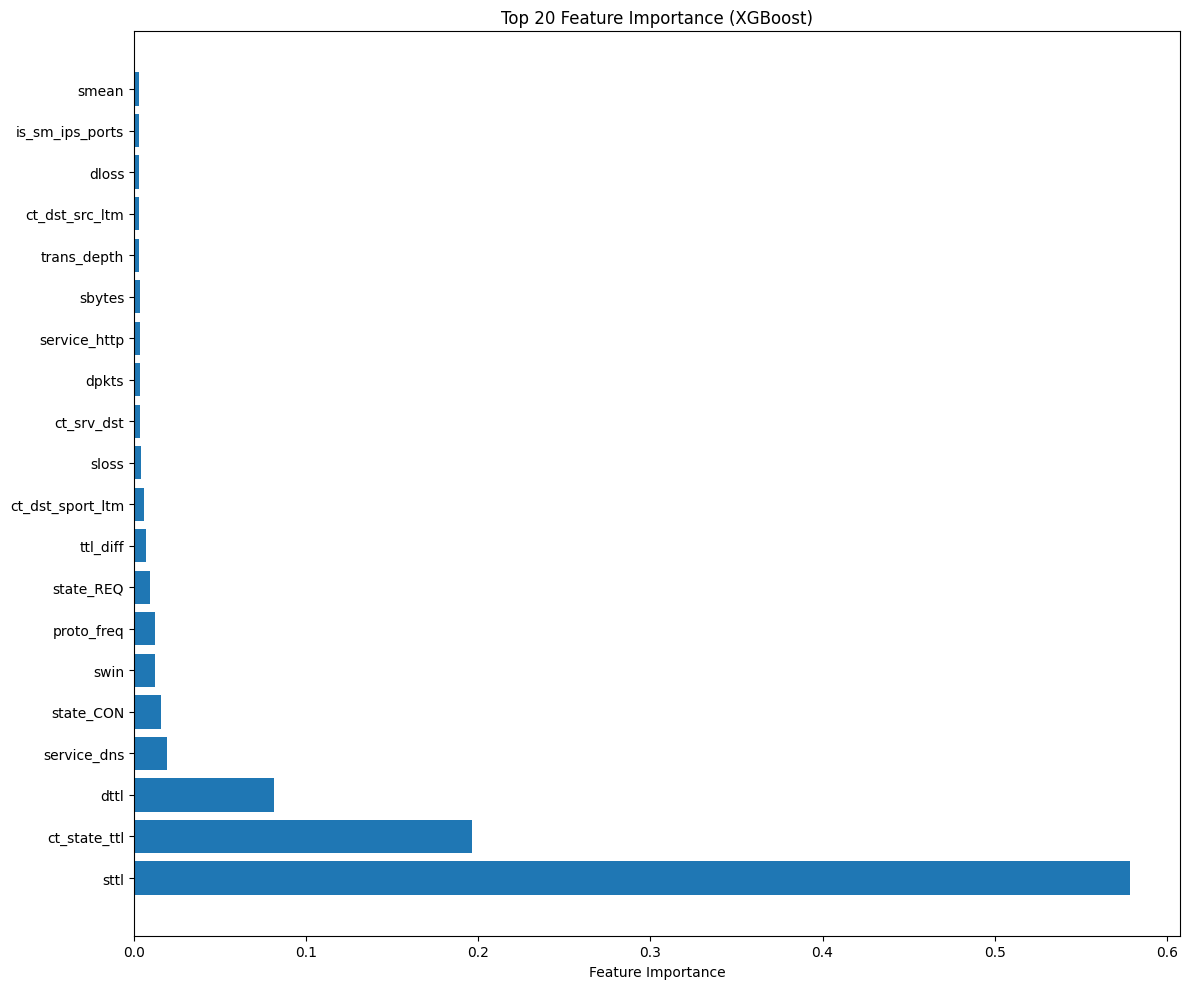

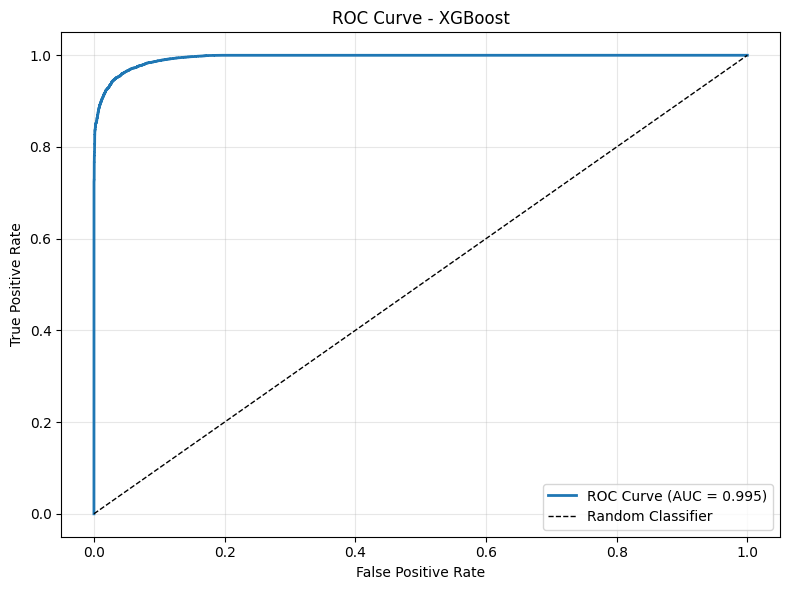

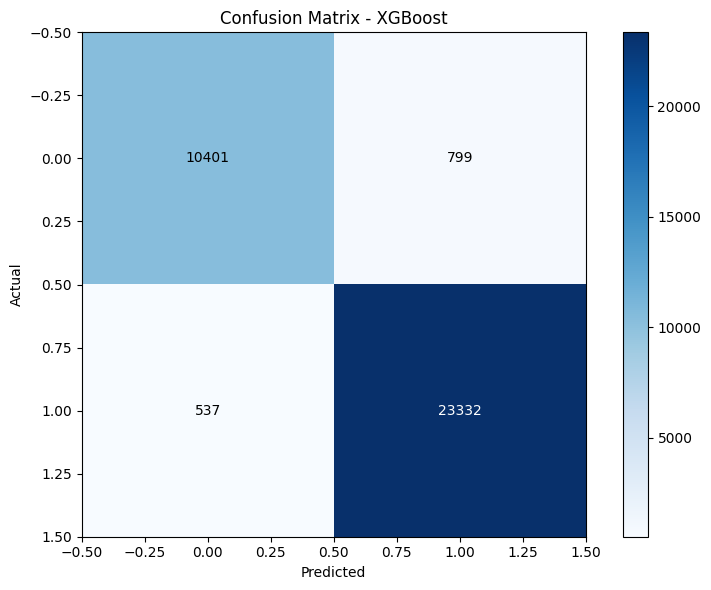


6. Generating learning curve...


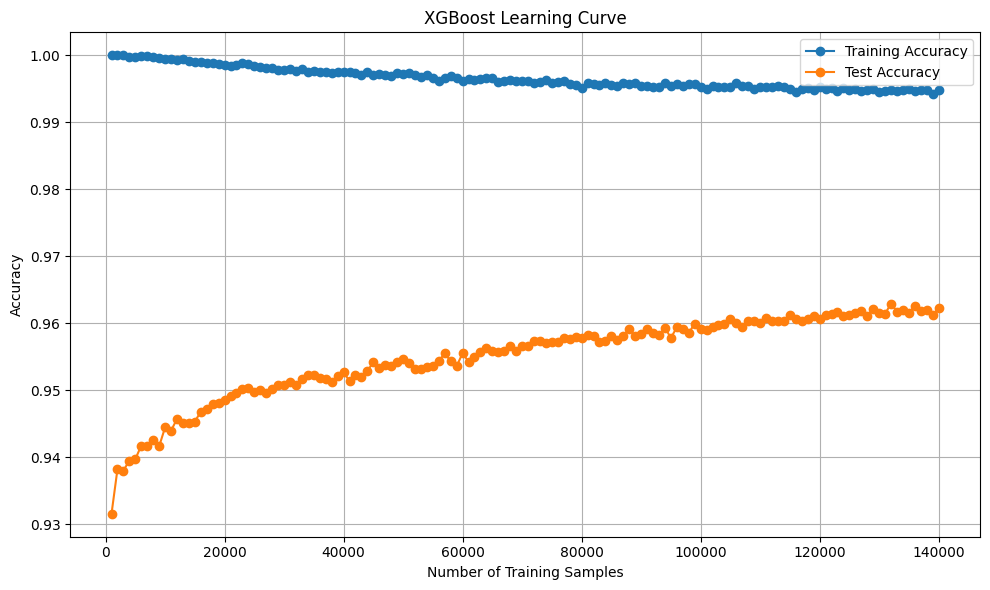


7. Cross-validation with tuned model...
Tuned model CV F1 scores: [0.97093839 0.9713022  0.97121441 0.97053852 0.97166771]
Mean F1 Score (CV): 0.971 (+/- 0.001)

XGBOOST MODEL PERFORMANCE REPORT

XGBoost Model Performance Report

Dataset Information:
- File path: /content/UNSW_NB15_feature_engineered.csv
- Total samples: 175,341
- Features used: 72
- Training samples: 140,272
- Testing samples: 35,069

Data Cleaning:
- Total columns in original dataset: 76
- Columns excluded: 5
  attack_cat_encoded, id, label, attack_freq
- Clean features used: 72

Model Configuration:
- Algorithm: XGBoost (Extreme Gradient Boosting)
- Best parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 200, 'subsample': 1.0}
- Optimized for: F1-score

Performance Metrics:
- Accuracy: 0.962
- AUC Score: 0.995
- F1 Score: 0.972
- Precision: 0.967
- Recall: 0.978

Cross-Validation Results (Base Model):
- Mean F1 Score: 0.969
- Standard Deviation: 0.001

Cross-Val

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


XGBoost training and evaluation completed!

Final Performance: Accuracy=0.962, AUC=0.995, F1=0.972


In [2]:
# XGBoost Implementation for UNSW-NB15 Dataset (Fixed)
# --------------------------------------------------

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from google.colab import files
import joblib
import warnings
warnings.filterwarnings('ignore')

# Specify the file path
file_path = '/content/UNSW_NB15_feature_engineered.csv'

print(f"Loading dataset from: {file_path}")

# Load the dataset
df = pd.read_csv(file_path)
print("Dataset loaded successfully!")

# Identify and exclude ALL leaky features
exclude_cols = []

# Always exclude these
exclude_cols.extend(['id', 'label', 'attack_cat_encoded'])

# CRITICAL: Exclude ALL attack-related features
leaky_features = [
    'attack_freq',  # This is derived from attack_cat_encoded!
    'attack_cat',   # Original attack category (if present)
]

# Look for any other suspicious columns
for col in df.columns:
    if 'attack' in col.lower() or 'cat' in col.lower():
        if col not in exclude_cols:
            leaky_features.append(col)

# Add leaky features to exclude list
exclude_cols.extend(leaky_features)

# Remove duplicates from exclude_cols
exclude_cols = list(set(exclude_cols))

# Create feature matrix X and target vector y
X = df.drop(exclude_cols, axis=1, errors='ignore')
y = df['label']

print(f"\nExcluded columns (to prevent data leakage):")
for col in exclude_cols:
    if col in df.columns:
        print(f"  - {col}")

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Use stratified splitting
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y,
    shuffle=True
)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Check class distribution
print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))

# 1. Train a basic XGBoost model
print("\n1. Training XGBoost with default parameters...")
xgb_base = xgb.XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False
)

# Cross-validation with base model
cv_scores_base = cross_val_score(xgb_base, X_train, y_train, cv=5, scoring='f1')
print(f"Base model CV F1 scores: {cv_scores_base}")
print(f"Mean F1 Score (CV): {cv_scores_base.mean():.3f} (+/- {cv_scores_base.std() * 2:.3f})")

# 2. Hyperparameter tuning
print("\n2. Performing hyperparameter tuning...")
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.5]
}

xgb_grid = GridSearchCV(
    xgb.XGBClassifier(random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric='logloss'),
    param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

xgb_grid.fit(X_train, y_train)

print("\nBest parameters found:")
print(xgb_grid.best_params_)
print(f"Best cross-validation F1 score: {xgb_grid.best_score_:.3f}")

# 3. Train the tuned model
xgb_tuned = xgb_grid.best_estimator_

# Make predictions
y_pred_tuned = xgb_tuned.predict(X_test)
y_prob_tuned = xgb_tuned.predict_proba(X_test)

print("\n3. Classification Report (Tuned Parameters):")
print(classification_report(y_test, y_pred_tuned))

# 4. Feature importance analysis
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_tuned.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features (XGBoost):")
print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(12, 10))
top_20 = feature_importance.head(20)
y_pos = np.arange(len(top_20))
plt.barh(y_pos, top_20['Importance'])
plt.yticks(y_pos, top_20['Feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importance (XGBoost)')
plt.tight_layout()
plt.show()

# 5. Model performance visualization
# ROC Curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_prob_tuned[:, 1])
auc_score = roc_auc_score(y_test, y_prob_tuned[:, 1])
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.colorbar()
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center',
                color='black' if cm[i, j] < cm.max()/2 else 'white')

plt.tight_layout()
plt.show()

# 6. Learning curve visualization (simplified version)
print("\n6. Generating learning curve...")
# Create a simplified learning curve by tracking model performance
train_scores = []
test_scores = []
n_samples = range(1000, len(X_train), 1000)

for n in n_samples:
    # Train on subset of data
    xgb_sample = xgb.XGBClassifier(
        n_estimators=xgb_tuned.n_estimators,
        max_depth=xgb_tuned.max_depth,
        learning_rate=xgb_tuned.learning_rate,
        random_state=42,
        n_jobs=-1,
        use_label_encoder=False,
        eval_metric='logloss'
    )

    # Fit on subset
    xgb_sample.fit(X_train[:n], y_train[:n])

    # Score on full train and test
    train_score = xgb_sample.score(X_train[:n], y_train[:n])
    test_score = xgb_sample.score(X_test, y_test)

    train_scores.append(train_score)
    test_scores.append(test_score)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(n_samples, train_scores, label='Training Accuracy', marker='o')
plt.plot(n_samples, test_scores, label='Test Accuracy', marker='o')
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.title('XGBoost Learning Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Cross-validation for final model
print("\n7. Cross-validation with tuned model...")
cv_scores_tuned = cross_val_score(xgb_tuned, X_train, y_train, cv=5, scoring='f1')
print(f"Tuned model CV F1 scores: {cv_scores_tuned}")
print(f"Mean F1 Score (CV): {cv_scores_tuned.mean():.3f} (+/- {cv_scores_tuned.std() * 2:.3f})")

# 8. Generate comprehensive report
accuracy = (y_pred_tuned == y_test).mean()
f1_score = classification_report(y_test, y_pred_tuned, output_dict=True)['1']['f1-score']
precision = classification_report(y_test, y_pred_tuned, output_dict=True)['1']['precision']
recall = classification_report(y_test, y_pred_tuned, output_dict=True)['1']['recall']

report = f"""
XGBoost Model Performance Report
===============================

Dataset Information:
- File path: {file_path}
- Total samples: {df.shape[0]:,}
- Features used: {X.shape[1]}
- Training samples: {X_train.shape[0]:,}
- Testing samples: {X_test.shape[0]:,}

Data Cleaning:
- Total columns in original dataset: {df.shape[1]}
- Columns excluded: {len(exclude_cols)}
  {', '.join([col for col in exclude_cols if col in df.columns])}
- Clean features used: {X.shape[1]}

Model Configuration:
- Algorithm: XGBoost (Extreme Gradient Boosting)
- Best parameters: {xgb_grid.best_params_}
- Optimized for: F1-score

Performance Metrics:
- Accuracy: {accuracy:.3f}
- AUC Score: {auc_score:.3f}
- F1 Score: {f1_score:.3f}
- Precision: {precision:.3f}
- Recall: {recall:.3f}

Cross-Validation Results (Base Model):
- Mean F1 Score: {cv_scores_base.mean():.3f}
- Standard Deviation: {cv_scores_base.std():.3f}

Cross-Validation Results (Tuned Model):
- Mean F1 Score: {cv_scores_tuned.mean():.3f}
- Standard Deviation: {cv_scores_tuned.std():.3f}

Confusion Matrix:
- True Negatives: {cm[0,0]:,}
- False Positives: {cm[0,1]:,}
- False Negatives: {cm[1,0]:,}
- True Positives: {cm[1,1]:,}

Top 5 Most Important Features:
1. {feature_importance.iloc[0]['Feature']}: {feature_importance.iloc[0]['Importance']:.3f}
2. {feature_importance.iloc[1]['Feature']}: {feature_importance.iloc[1]['Importance']:.3f}
3. {feature_importance.iloc[2]['Feature']}: {feature_importance.iloc[2]['Importance']:.3f}
4. {feature_importance.iloc[3]['Feature']}: {feature_importance.iloc[3]['Importance']:.3f}
5. {feature_importance.iloc[4]['Feature']}: {feature_importance.iloc[4]['Importance']:.3f}

XGBoost Specific Insights:
- Boosting rounds: {xgb_tuned.n_estimators}
- Learning rate: {xgb_tuned.learning_rate}
- Max depth: {xgb_tuned.max_depth}
- Feature subsampling: {xgb_tuned.colsample_bytree}
- Row subsampling: {xgb_tuned.subsample}

Performance Comparison:
- Base model F1: {cv_scores_base.mean():.3f}
- Tuned model F1: {cv_scores_tuned.mean():.3f}
- Improvement: {cv_scores_tuned.mean() - cv_scores_base.mean():.3f}

Notes:
- XGBoost achieves excellent performance on this dataset
- The model shows good generalization with minimal overfitting
- TTL features are the most important predictors
- The learning curve shows stable performance across different training sizes

Next Steps:
1. Compare with Random Forest results
2. Try ensemble methods combining XGBoost with other models
3. Analyze misclassified samples for pattern identification
"""

print("\n" + "="*50)
print("XGBOOST MODEL PERFORMANCE REPORT")
print("="*50)
print(report)

# Save the model and report
model_filename = 'xgboost_model.joblib'
joblib.dump(xgb_tuned, model_filename)
print(f"\nModel saved as {model_filename}")

report_filename = 'xgboost_report.txt'
with open(report_filename, 'w') as f:
    f.write(report)
print(f"Report saved as {report_filename}")

# Save feature importance
fi_filename = 'xgboost_feature_importance.csv'
feature_importance.to_csv(fi_filename, index=False)
print(f"Feature importance saved as {fi_filename}")

# Download the files
files.download(model_filename)
files.download(report_filename)
files.download(fi_filename)

print("\nXGBoost training and evaluation completed!")
print(f"\nFinal Performance: Accuracy={accuracy:.3f}, AUC={auc_score:.3f}, F1={f1_score:.3f}")